 # Test and Finetune LLM Evaluation

In [1]:
# %%
import functools as ft
import logging
import random
import sys

import dspy
import numpy as np
import pandas as pd
from dspy.evaluate import Evaluate
from dspy.teleprompt import (
    BootstrapFewShot,
    BootstrapFewShotWithRandomSearch,
    LabeledFewShot,
)
from IPython.display import HTML, display
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tqdm import trange

random.seed(33)


def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n", "<br>")))


logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

# parameters
model_name = "openchat/openchat-3.5-0106"

 ## Connect to model and DB

In [2]:
# %%
logger.info("Connecting to model: " + model_name)
model = dspy.OpenAI(
    api_base="http://localhost:8000/v1/",
    api_key="vllm",
    model=model_name,
    stop="<|end_of_turn|>",
    model_type="chat",
)
dspy.settings.configure(lm=model)
# this is important for assertions to work (NoneType error)
dspy.configure(trace=[])

Connecting to model: openchat/openchat-3.5-0106


 ## Load training data

In [ ]:
# %%
df_train_test = pd.read_csv("../data/bot_training.csv", dtype="object")
# df_train_test = pd.read_csv("bundeschatbot/data/bot_training.csv", dtype="object")
df_train_test.head()

### Label count

- 0: question has no meaning
- 1: fallback answer ("I don't know")
- 2: topic of response does not match the topic of the question
- 3: topic of response matches the topic of the question but response does not answer the question
- 4: correct answer to question

In [4]:
# %%
df_train_test["evaluation"].value_counts()

evaluation
4    104
2     41
3     40
1     25
0     24
Name: count, dtype: int64

 ### Meaningless questions

In [ ]:
# %%
df_train_test_zero = df_train_test[df_train_test["evaluation"] == "0"]
df_train_test = df_train_test[df_train_test["evaluation"] != "0"]
pretty_print(df_train_test_zero[["text"]])

 ### Downsampling

In [6]:
# %%
max_class_size = 40


def downsample_class(i, max_class_size):
    df_class = df_train_test[df_train_test["evaluation"] == i]
    return resample(
        df_class,
        replace=False,
        n_samples=min(len(df_class), max_class_size),
        random_state=34,
    )


df_train_test_downsampled = pd.concat(
    [downsample_class(i, max_class_size) for i in df_train_test["evaluation"].unique()]
)
df_train_test_downsampled["evaluation"].value_counts()

evaluation
4    40
3    40
2    40
1    25
Name: count, dtype: int64

 ### Create training-, dev- and testset

In [7]:
# %%

train_dev, test = train_test_split(
    df_train_test_downsampled,
    test_size=0.33,
    stratify=df_train_test_downsampled["evaluation"],
    random_state=35,
)
train, dev = train_test_split(
    train_dev,
    test_size=0.5,
    stratify=train_dev["evaluation"],
    random_state=36,
)

# show classes counts
ft.reduce(
    lambda left, right: pd.merge(
        left,
        right,
        left_index=True,
        right_index=True,
    ),
    [
        value["evaluation"].value_counts().to_frame().rename(columns={"count": key})
        for key, value in {
            "train": train,
            "dev": dev,
            "test": test,
        }.items()
    ],
).sort_index()

train  dev  test
evaluation                  
1               8    8     9
2              13   14    13
3              13   14    13
4              14   13    13

 ## Defining the DSPy Module

In [8]:
# %%
class CheckAnswerFallback(dspy.Signature):
    """
    Your are given the response to a question.
    Your task is to evaluate whether the given response is a fallback answer stating e.g.
    that the question was not understood or the answer is not known.

    Write as result either 'yes' or 'no'
    Please do not generate any other opening, closing, and explanations.
    """

    response = dspy.InputField(desc="the response to a question")
    fallback = dspy.OutputField(desc="either 'yes' or 'no'")


class CheckFallback(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.Predict(CheckAnswerFallback)

    def forward(self, response):
        return self.prog(response=response)


class CheckAnswerTopic(dspy.Signature):
    """
    Your are given a question and a response to the question.
    Your task is to evaluate whether the given response of the same topic as the question.

    Write as result either 'yes' or 'no'
    Please do not generate any other opening, closing, and explanations.
    """

    question = dspy.InputField(desc="the question")
    response = dspy.InputField(desc="the response to the question")
    same_topic = dspy.OutputField(desc="either 'yes' or 'no'")


class CheckTopic(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought(CheckAnswerTopic)

    def forward(self, question, response):
        return self.prog(question=question, response=response)


class CheckAnswerCorrectness(dspy.Signature):
    """
    Your are given a question and a response to the question.
    Your task is to evaluate whether the given response is a correct answer to the question.

    Write as result either 'yes' or 'no'
    Please do not generate any other opening, closing, and explanations.
    """

    question = dspy.InputField(desc="the question")
    response = dspy.InputField(desc="the response to the question")
    correctness = dspy.OutputField(desc="either 'yes' or 'no'")


class CheckCorrectness(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought(CheckAnswerCorrectness)

    def forward(self, question, response):
        return self.prog(question=question, response=response)

 ## Evaluation



 ### Fallback classification

100%|██████████| 48/48 [00:00<00:00, 1111.69it/s]


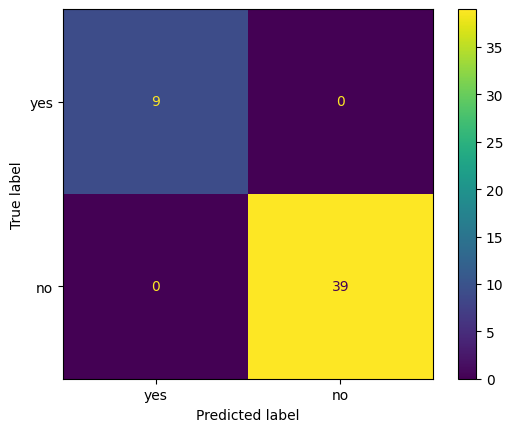

In [9]:
# %%
def llm_predict_fallback(model, df):
    df = df.copy(deep=True)

    df["llm_fallback"] = ""

    for i in trange(len(df)):
        # i = 0
        llm_response = model.forward(response=df.iloc[i].response)

        df.iloc[i, df.columns.get_loc("llm_fallback")] = llm_response.fallback

    df["fallback"] = np.where(df["evaluation"] == "1", "yes", "no")

    return df


test_fallback = llm_predict_fallback(model=CheckFallback(), df=test)
cm = confusion_matrix(
    test_fallback["fallback"], test_fallback["llm_fallback"], labels=["yes", "no"]
)
disp = ConfusionMatrixDisplay(cm, display_labels=["yes", "no"])
disp.plot()


# ### Topic evaluation

100%|██████████| 39/39 [00:00<00:00, 803.85it/s]


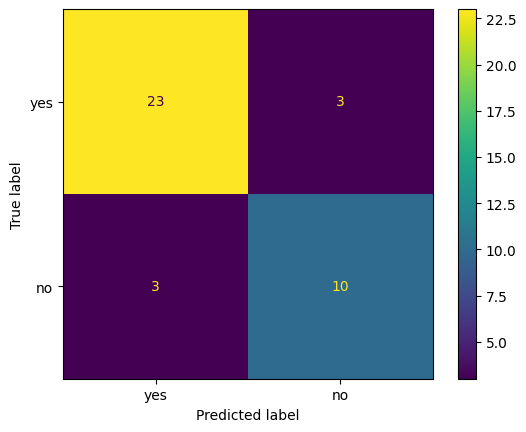

In [10]:
# %%
def llm_predict_same_topic(model, df):
    df = df.copy(deep=True)

    df["llm_same_topic"] = ""
    df["llm_same_topic_rationale"] = ""

    for i in trange(len(df)):
        # i = 0
        llm_response = model.forward(
            question=df.iloc[i].text, response=df.iloc[i].response
        )

        df.iloc[i, df.columns.get_loc("llm_same_topic_rationale")] = (
            llm_response.rationale
        )
        df.iloc[i, df.columns.get_loc("llm_same_topic")] = llm_response.same_topic

    df["same_topic"] = np.where(df["evaluation"] == "2", "no", "yes")
    df["same_topic"] = np.where(df["evaluation"] == "1", "", df["same_topic"])

    return df


test_topic = llm_predict_same_topic(
    model=CheckTopic(), df=test_fallback[test_fallback["llm_fallback"] == "no"]
)


cm = confusion_matrix(
    test_topic["same_topic"], test_topic["llm_same_topic"], labels=["yes", "no"]
)
disp = ConfusionMatrixDisplay(cm, display_labels=["yes", "no"])
disp.plot()

 ### Answer Correctness



100%|██████████| 26/26 [00:00<00:00, 755.06it/s]


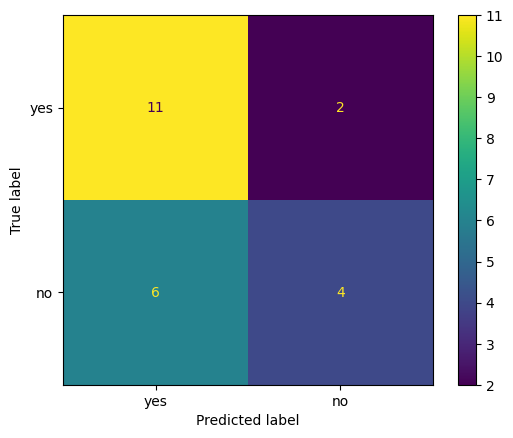

In [11]:
# %%
def llm_predict_correctness(model, df):
    df = df.copy(deep=True)

    df["llm_correctness"] = ""
    df["llm_correctness_rationale"] = ""

    for i in trange(len(df)):
        # i = 0
        llm_response = model.forward(
            question=df.iloc[i].text, response=df.iloc[i].response
        )

        df.iloc[i, df.columns.get_loc("llm_correctness_rationale")] = (
            llm_response.rationale
        )
        df.iloc[i, df.columns.get_loc("llm_correctness")] = llm_response.correctness

    df["correctness"] = np.where(df["evaluation"] == "3", "no", "yes")
    df["correctness"] = np.where(
        df["evaluation"].isin(["1", "2"]), "", df["correctness"]
    )
    return df


test_correctness = llm_predict_correctness(
    model=CheckCorrectness(), df=test_topic[test_topic["llm_same_topic"] == "yes"]
)

cm = confusion_matrix(
    test_correctness["correctness"],
    test_correctness["llm_correctness"],
    labels=["yes", "no"],
)
disp = ConfusionMatrixDisplay(cm, display_labels=["yes", "no"])
disp.plot()

 ### Full Confusion Matrix



Accuracy: 0.71


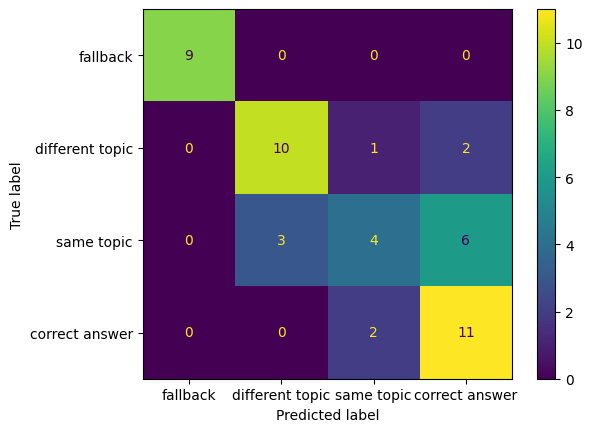

In [12]:
# %%
def plot_cm(df):
    cm = confusion_matrix(
        df["evaluation"], df["llm_score"], labels=["1", "2", "3", "4"]
    )
    disp = ConfusionMatrixDisplay(
        cm,
        display_labels=["fallback", "different topic", "same topic", "correct answer"],
    )
    disp.plot()


def accuracy(df):
    return accuracy_score(df["evaluation"], df["llm_score"])


def combine_test_dfs(test_fallback, test_topic, test_correctness):
    test_score = pd.concat(
        [
            test_fallback[test_fallback["llm_fallback"] == "yes"],
            test_topic[test_topic["llm_same_topic"] == "no"],
            test_correctness,
        ]
    )

    test_score["llm_score"] = np.where(test_score["llm_fallback"] == "yes", "1", "")
    test_score["llm_score"] = np.where(
        test_score["llm_same_topic"] == "no", "2", test_score["llm_score"]
    )
    test_score["llm_score"] = np.where(
        test_score["llm_correctness"] == "no", "3", test_score["llm_score"]
    )
    test_score["llm_score"] = np.where(
        test_score["llm_correctness"] == "yes", "4", test_score["llm_score"]
    )
    return test_score


test_score = combine_test_dfs(test_fallback, test_topic, test_correctness)
print(f"Accuracy: {accuracy(test_score):.2f}")
plot_cm(test_score)

 ## Optimisation



In [13]:
# %%
def create_example(question, response, score):
    return dspy.Example(
        question=question, response=response, score=str(score)
    ).with_inputs("question", "response")


def convert_df_to_examples(df):
    return list(
        df.apply(
            lambda x: create_example(x["text"], x["response"], x["evaluation"]), axis=1
        )
    )


def validate_score(example, pred, trace=None):
    return str(example.score) == str(pred.correctness)

 ### LabeledFewShot



100%|██████████| 26/26 [00:00<00:00, 1278.42it/s]


Accuracy: 0.71


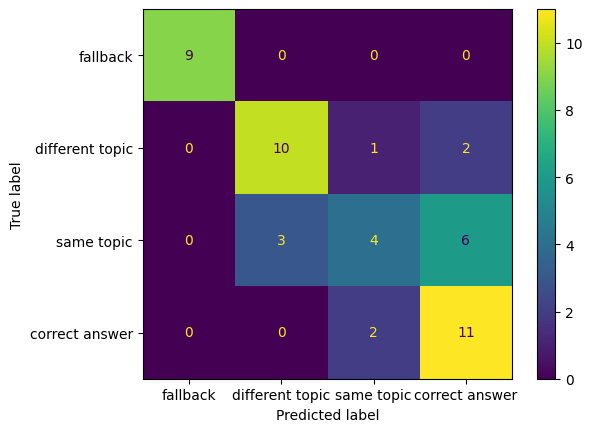

In [14]:
# %%
df_stratified = (
    train[train["evaluation"].isin(["3", "4"])]
    .groupby("evaluation")
    .apply(lambda x: x.sample(min(len(x), 5), random_state=23), include_groups=False)
    .reset_index(["evaluation"])
    .replace({"evaluation": {"3": "no", "4": "yes"}})
)


labeled_fewshot_optimizer = LabeledFewShot()
labeled_optimized_check_answer = labeled_fewshot_optimizer.compile(
    student=CheckCorrectness(),
    trainset=convert_df_to_examples(df_stratified),
    sample=False,
)

# labeled_optimized_check_answer.predictors()[0].demos

test_correctness_optimised = llm_predict_correctness(
    model=labeled_optimized_check_answer,
    df=test_topic[test_topic["llm_same_topic"] == "yes"],
)

test_score_optimised = combine_test_dfs(
    test_fallback, test_topic, test_correctness_optimised
)

print(f"Accuracy: {accuracy(test_score_optimised):.2f}")
plot_cm(test_score_optimised)

 ### BootstrapFewShot



 52%|█████▏    | 14/27 [00:00<00:00, 926.63it/s]


Bootstrapped 10 full traces after 15 examples in round 0.


100%|██████████| 26/26 [00:00<00:00, 557.49it/s]


Accuracy: 0.73


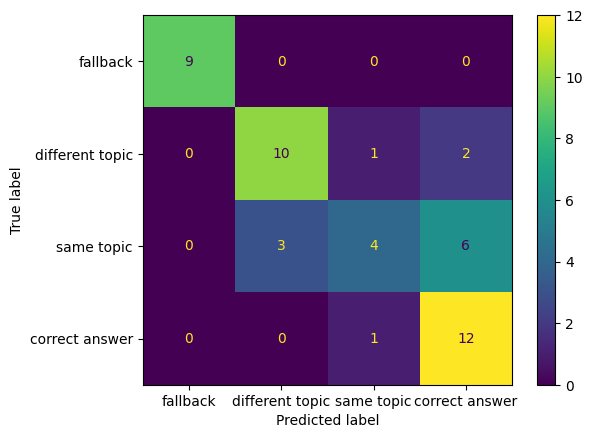

In [15]:
# %%
config = dict(max_bootstrapped_demos=10, max_labeled_demos=10)
bootstrap_fewshot_optimizer = BootstrapFewShot(metric=validate_score, **config)
bootstrap_optimized_check_answer = bootstrap_fewshot_optimizer.compile(
    student=CheckCorrectness(),
    trainset=convert_df_to_examples(
        train[train["evaluation"].isin(["3", "4"])].replace(
            {"evaluation": {"3": "no", "4": "yes"}}
        )
    ),
    valset=convert_df_to_examples(
        dev[dev["evaluation"].isin(["3", "4"])].replace(
            {"evaluation": {"3": "no", "4": "yes"}}
        )
    ),
)

test_correctness_optimised_bootstrap = llm_predict_correctness(
    model=bootstrap_optimized_check_answer,
    df=test_topic[test_topic["llm_same_topic"] == "yes"],
)


test_score_optimised_bootstrap = combine_test_dfs(
    test_fallback, test_topic, test_correctness_optimised_bootstrap
)
print(f"Accuracy: {accuracy(test_score_optimised_bootstrap):.2f}")
plot_cm(test_score_optimised_bootstrap)

 ### BootstrapFewShotWithRandomSearch



In [ ]:
# %%
config = dict(
    max_bootstrapped_demos=10,
    max_labeled_demos=10,
    num_candidate_programs=10,
    num_threads=4,
)

bootstrap_search_fewshot_optimizer = BootstrapFewShotWithRandomSearch(
    metric=validate_score, **config
)
bootstrap_search_optimized_check_answer = bootstrap_search_fewshot_optimizer.compile(
    student=CheckCorrectness(),
    trainset=convert_df_to_examples(
        train[train["evaluation"].isin(["3", "4"])].replace(
            {"evaluation": {"3": "no", "4": "yes"}}
        )
    ),
    valset=convert_df_to_examples(
        dev[dev["evaluation"].isin(["3", "4"])].replace(
            {"evaluation": {"3": "no", "4": "yes"}}
        )
    ),
)

100%|██████████| 26/26 [00:00<00:00, 1361.26it/s]


Accuracy: 0.71


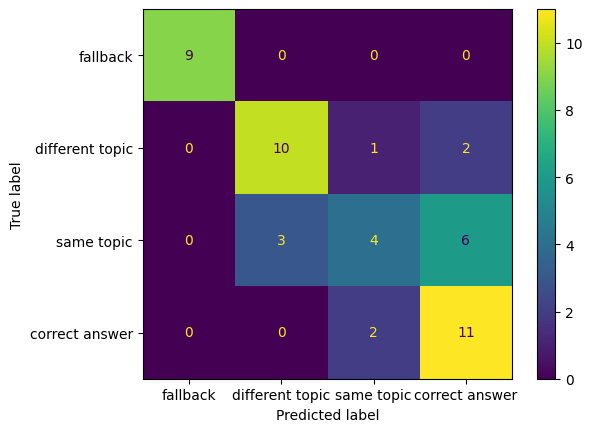

In [17]:
# %%
bootstrap_search_optimized_check_answer.predictors()[0].demos

test_correctness_optimised_bootstrap_search = llm_predict_correctness(
    model=bootstrap_search_optimized_check_answer,
    df=test_topic[test_topic["llm_same_topic"] == "yes"],
)


test_score_optimised_bootstrap_search = combine_test_dfs(
    test_fallback, test_topic, test_correctness_optimised_bootstrap_search
)
print(f"Accuracy: {accuracy(test_score_optimised_bootstrap_search):.2f}")
plot_cm(test_score_optimised_bootstrap_search)

In [18]:
# %%
# save model
# bootstrap_search_optimized_check_answer.save("../models/optimised_check_answer")